# Neural Network

In [44]:
!pip install optuna


## Load Data

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from hotel_preprocessing import clean_data, extract_features, drop_columns, XYPreprocessor



# Load dataset
df = pd.read_csv("hotel_bookings.csv")  # alr scaled, clean data
hotel = df.copy()


In [36]:
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Split Data into Training, Validation, Test

In [41]:
def prepare_time_based_split(df):
    """Create time-based train/validation/test splits"""
    print("Creating time-based splits...")
    
    # Sort by reservation status date
    df_sorted = df.sort_values('reservation_status_date')
    
    # Calculate split points (70% train, 15% validation, 15% test - last 3 months)
    total_rows = len(df_sorted)
    train_end = int(0.70 * total_rows)
    val_end = int(0.85 * total_rows)
    
    train_df = df_sorted.iloc[:train_end].copy()
    val_df = df_sorted.iloc[train_end:val_end].copy()
    test_df = df_sorted.iloc[val_end:].copy()  # Last 15% as holdout test set
    
    print(f"Train set: {len(train_df)} samples ({train_df['reservation_status_date'].min()} to {train_df['reservation_status_date'].max()})")
    print(f"Validation set: {len(val_df)} samples ({val_df['reservation_status_date'].min()} to {val_df['reservation_status_date'].max()})")
    print(f"Test set: {len(test_df)} samples ({test_df['reservation_status_date'].min()} to {test_df['reservation_status_date'].max()})")
    
    # Check class distribution
    print(f"Train cancellation rate: {train_df['is_canceled'].mean():.3f}")
    print(f"Validation cancellation rate: {val_df['is_canceled'].mean():.3f}")
    print(f"Test cancellation rate: {test_df['is_canceled'].mean():.3f}")
    
    return train_df, val_df, test_df

In [42]:
train_df, val_df, test_df = prepare_time_based_split(hotel)

Creating time-based splits...
Train set: 83573 samples (2014-10-17 to 2017-01-05)
Validation set: 17908 samples (2017-01-05 to 2017-04-24)
Test set: 17909 samples (2017-04-24 to 2017-09-14)
Train cancellation rate: 0.398
Validation cancellation rate: 0.411
Test cancellation rate: 0.201


## Preprocess + Clean data

In [43]:
X_train = train_df.drop(columns='is_canceled')
y_train = train_df['is_canceled']

X_val = val_df.drop(columns='is_canceled')
y_val = val_df['is_canceled']

X_test = test_df.drop(columns='is_canceled')
y_test = test_df['is_canceled']

# Initialize and fit preprocessor on training data only
preprocessor = XYPreprocessor()

# Fit and transform training data
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train, y_train)

# Transform validation and test sets using same preprocessor
X_val_processed, y_val_processed = preprocessor.transform(X_val, y_val)
X_test_processed, y_test_processed = preprocessor.transform(X_test, y_test)

## Neural Network Model Training

In [45]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import optuna

# --- Neural Network Definition ---
class CancellationNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(CancellationNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout / 2),

            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).squeeze()


In [ ]:
# --- Training Function ---
def train_model(X, y, params, device):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    # 5-fold cross-validation
    val_aucs = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = CancellationNet(X.shape[1], params['hidden_dim'], params['dropout']).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

        train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=params['batch_size'], shuffle=True)

        best_auc = 0
        patience = 3
        counter = 0

        for epoch in range(params['epochs']):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_preds = model(X_val.to(device)).cpu().numpy()
                auc = roc_auc_score(y_val.numpy(), val_preds)
                scheduler.step(auc)

                if auc > best_auc:
                    best_auc = auc
                    counter = 0
                else:
                    counter += 1

            if counter >= patience:
                break

        val_aucs.append(best_auc)

    return np.mean(val_aucs)

In [48]:
X_train_tensor = torch.tensor(X_train_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_processed.values, dtype=torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
# --- Optuna Objective Function ---
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'epochs': trial.suggest_int('epochs', 5, 15)
    }
    return train_model(X_train_tensor, y_train_tensor, params, device)

# --- Run Hyperparameter Tuning ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
print("\n✅ Best Validation AUC: {:.4f}".format(study.best_value))
print("Best Hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-15 15:16:13,233] A new study created in memory with name: no-name-81176170-6568-4952-ab47-bec39ed3d61c
[I 2025-06-15 15:16:48,682] Trial 0 finished with value: 0.9312530213715341 and parameters: {'hidden_dim': 128, 'dropout': 0.3720939873177973, 'lr': 0.0014052293995761608, 'batch_size': 128, 'epochs': 7}. Best is trial 0 with value: 0.9312530213715341.
[I 2025-06-15 15:18:35,868] Trial 1 finished with value: 0.9213519201304621 and parameters: {'hidden_dim': 256, 'dropout': 0.26887266430504225, 'lr': 3.595281880644162e-05, 'batch_size': 64, 'epochs': 13}. Best is trial 0 with value: 0.9312530213715341.
[I 2025-06-15 15:19:37,516] Trial 2 finished with value: 0.93191602175333 and parameters: {'hidden_dim': 128, 'dropout': 0.49198663772326984, 'lr': 0.0062415932419169415, 'batch_size': 64, 'epochs': 9}. Best is trial 2 with value: 0.93191602175333.
[I 2025-06-15 15:22:12,219] Trial 3 finished with value: 0.9328215117961255 and parameters: {'hidden_dim': 256, 'dropout': 0.45825


✅ Best Validation AUC: 0.9349
Best Hyperparameters:
  hidden_dim: 256
  dropout: 0.20089182317971815
  lr: 0.0005607338089499992
  batch_size: 32
  epochs: 9


In [51]:
import joblib
# Save the best hyperparameters
joblib.dump(best_params, "best_hyperparameters.pkl")
# --- Final Training on Train Set ---
final_model = CancellationNet(X_train_tensor.shape[1], best_params['hidden_dim'], best_params['dropout']).to(device)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=1e-4)
criterion = nn.BCELoss()

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params['batch_size'], shuffle=True)
X_test_tensor = torch.tensor(X_test_processed.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_processed.values, dtype=torch.float32)

final_model.train()
for epoch in range(best_params['epochs']):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
# save best model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_hyperparams': best_params
}, "best_nn_model_full.pth")

# --- Evaluate on Test Set ---
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test_tensor.to(device)).cpu().numpy()
    test_binary = (test_preds >= 0.5).astype(int)
    y_true = y_test_tensor.cpu().numpy()

# --- Evaluation Metrics ---
test_auc = roc_auc_score(y_true, test_preds)
acc = accuracy_score(y_true, test_binary)
prec = precision_score(y_true, test_binary)
rec = recall_score(y_true, test_binary)
f1 = f1_score(y_true, test_binary)

print("\n📊 Final Test Set Evaluation:")
print(f"AUC:       {test_auc:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


📊 Final Test Set Evaluation:
AUC:       0.7148
Accuracy:  0.3538
Precision: 0.2217
Recall:    0.9601
F1 Score:  0.3602


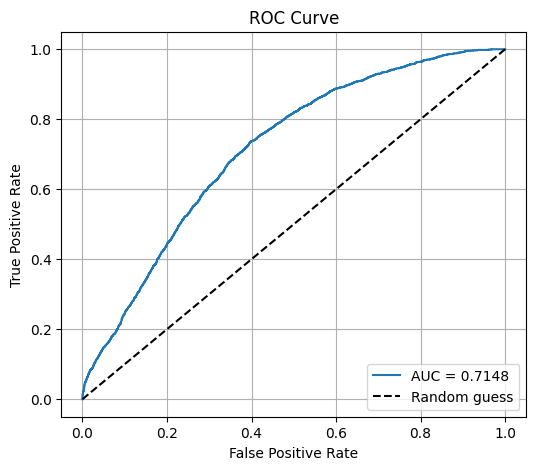

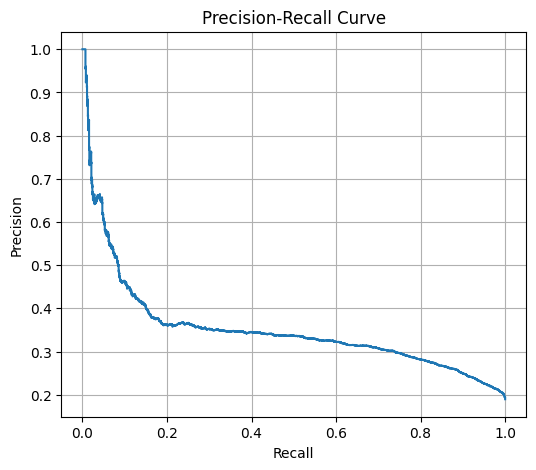

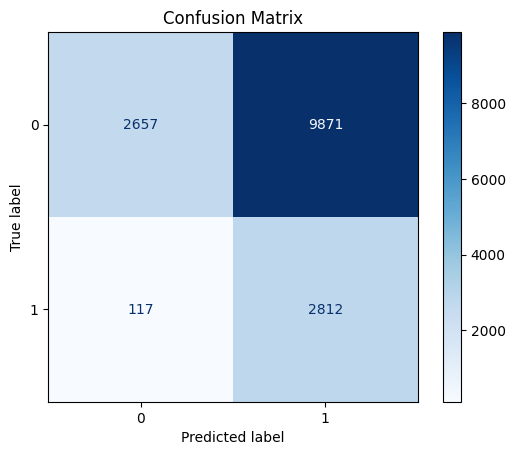

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# --- Plot ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Plot Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# --- Plot Confusion Matrix ---
cm = confusion_matrix(y_true, test_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()